In [3]:
using StatsBase, Random, LinearAlgebra, DecisionTree, DataFrames, MLDataUtils, ScikitLearn, CSV, Plots, Gurobi, JuMP, Plots.PlotMeasures

In [4]:
using JLD

# Scenario Generation

In [11]:
function scenario_generation(y_neighbors,method="knn")
    """
    generate scenarios of cancelation/non-cancelation based on historic data.
    Procedure will depend on whether the prescriptive method is knn or OCT
    
    @param y_neighbors: n x k matrix holding possible cancelation scenarios for each observation
    """
    n,k = size(y_neighbors)
    y_hat = zeros(n) 
    if method == "knn"
        for i=1:n
            p = sum(y_neighbors[i,:])/k
            y_hat[i] = p  #(rand() < p) ? 1 : 0 #1 with probability p, otherwise 0
        end
    end
    return y_hat
end

scenario_generation (generic function with 2 methods)

In [12]:
s = vec(Matrix(CSV.read("s.csv",DataFrame; header=0)));
s = broadcast(x -> Integer(x), s)
e = vec(Matrix(CSV.read("e.csv",DataFrame; header=0)));
e = broadcast(x -> Integer(x), e)
p = vec(Matrix(CSV.read("p.csv",DataFrame; header=0)));
t = vec(Matrix(CSV.read("t.csv",DataFrame; header=0)));
t = broadcast(x -> Integer(x), t)
y_neighbors = (Matrix(CSV.read("y_neighbors.csv",DataFrame; header=0)));
room_capacities = 100
Q = ones(5).*room_capacities #vec([5,5,5,5,5,5]);
M = 10^5;
f = 50;
q = 500;

In [13]:
X_new = (Matrix(CSV.read("X_new.csv",DataFrame; header=0)));
y_new = vec(Matrix(CSV.read("y_new.csv",DataFrame; header=0)));
y_new = broadcast(x -> Integer(x), y_new);
y_hat =  scenario_generation(y_neighbors);

# Baseline Approach

The baseline approach will never allow a scenario where overbooking could happen.

In [14]:
function prescribe_bookings_baseline(Q,q,f,p,s,e,t)
    """
    A function that receives n booking requests over a time period 1,...,T and returns
    a decision on each booking (accept or reject) so as to maximize revenue.
    
    @param Q: vector length J. J is the number of room types we have (1 person, 2 person, etc.) Q_j is 
    the number of rooms available we have of type j 
    @param q: constant. this is the cost incurred if a customer is overbooked 
    @param f: constant. Money received if a booking is canceled 
    @param p: vector length n. The price of each booking 
    @param s: vector length n. The starting day of each booking
    @param e: vector length n. The ending day of each booking
    @param t: vector length n. This gives the number of people that the ith booking is for
    @param y_neighbors: binary matrix n X K. This is the historical neighbour data,
                        whether the person canceled or not
    @param M: big M constraints
    @param y_hat: estimate of cancelation probabilities 
    """
    J = length(Q)
    n = length(s)
    
    gurobi_env=Gurobi.Env(); #to suppress some Gurobi outputs
    model = Model(with_optimizer(Gurobi.Optimizer, gurobi_env))
    set_optimizer_attribute(model, "OutputFlag", 0)
    #set_optimizer_attribute(model, "MIPGap", 0.1) #needed to ensure convergence

    
    @variable(model,z[i=1:n],Bin) #accept booking i or not

    #STRATEGY: Never allow num_people_booked > capacity 
    for i=1:n
        booked_people = 0 
        for i2=1:n
            if (s[i2] <= s[i]) && (e[i2] > s[i]) && (i2 !== i) && (t[i2] == t[i])
                booked_people += 1*z[i2]
            end
        end            
        @constraint(model,booked_people <= Q[t[i]])
    end
    
    @objective(model,Max, sum(z[i]*p[i] for i=1:n))
    optimize!(model)
    return objective_value(model) , value.(z)
end

prescribe_bookings_baseline (generic function with 1 method)

In [7]:
obj_baseline, z_baseline = prescribe_bookings_baseline(Q,q,f,p,s,e,t);

Academic license - for non-commercial use only - expires 2022-08-18


┌ Warning: The addition operator has been used on JuMP expressions a large number of times. This warning is safe to ignore but may indicate that model generation is slower than necessary. For performance reasons, you should not add expressions in a loop. Instead of x += y, use add_to_expression!(x,y) to modify x in place. If y is a single variable, you may also use add_to_expression!(x, coef, y) for x += coef*y.
└ @ JuMP /Users/iai/builds/InterpretableAI/SystemImage/SysImgBuilder/.julia/packages/JuMP/qhoVb/src/JuMP.jl:972


# kNN-based prescriptions

In [15]:
function prescribe_bookings_knn_new(Q,q,f,p,s,e,t,y_neighbors,y_hat)
    """
    A function that receives n booking requests over a time period 1,...,T and returns
    a decision on each booking (accept or reject) so as to maximize revenue.
    
    @param Q: vector length J. J is the number of room types we have (1 person, 2 person, etc.) Q_j is 
    the number of rooms available we have of type j 
    @param q: constant. this is the cost incurred if a customer is overbooked 
    @param f: constant. Money received if a booking is canceled 
    @param p: vector length n. The price of each booking 
    @param s: vector length n. The starting day of each booking
    @param e: vector length n. The ending day of each booking
    @param t: vector length n. This gives the number of people that the ith booking is for
    @param y_neighbors: binary matrix n X K. This is the historical neighbour data,
                        whether the person canceled or not
    @param M: big M constraints
    @param y_hat: estimate of whether people will cancel or not 
    """
    J = length(Q)
    n,K = size(y_neighbors)
    s = s .+ 1
    T = Int(maximum(s))
    
    gurobi_env=Gurobi.Env(); #to suppress some Gurobi outputs
    model = Model(with_optimizer(Gurobi.Optimizer, gurobi_env))
    set_optimizer_attribute(model, "OutputFlag", 0)
    #set_optimizer_attribute(model, "MIPGap", 0.1) #needed to ensure convergence

    
    @variable(model,z[i=1:n],Bin) #accept booking i or not
    @variable(model,m[time=1:T,j=1:J]) #model ith min (for penalty terms)
    @variable(model,exp_occupancy[time=1:T,j=1:J]) #expected occupancy at time t for room size j
    
    #STRATEGY: multiply expected surplus by q to penalise overbooking in objective

    obj = 0
    for time=1:T
        for j=1:J
            expected_people = 0
            for i=1:n
                if (s[i] <= time) && (e[i] > time) && (t[i] == j)
                    expected_people += z[i]*(1-y_hat[i])*1
                end
            end   
            @constraint(model, exp_occupancy[time,j] == expected_people)
            @constraint(model, m[time,j] <= 0)
            @constraint(model, m[time,j] <= Q[j] - exp_occupancy[time,j])
            #objective_term = min(Q[t[i]] - expected_people,0)*(q/n)
            if length(p[s.==time]) >= 1
                day_avg =  mean(p[s.==time])
            else
                day_avg = 0
            end
            obj += m[time,j]*(q+day_avg) #(q/n)
        end
    end
    
    obj += sum((1/K)*z[i]*(y_neighbors[i,k]*f + (1-y_neighbors[i,k])*p[i]) for k=1:K for i=1:n)
    
    @objective(model,Max, obj)
    optimize!(model)
    return objective_value(model) , value.(z), value.(m), value.(exp_occupancy)
end

prescribe_bookings_knn_new (generic function with 1 method)

In [16]:
function prescribe_bookings_knn(Q,q,f,p,s,e,t,y_neighbors,y_hat;alpha=1)
    """
    A function that receives n booking requests over a time period 1,...,T and returns
    a decision on each booking (accept or reject) so as to maximize revenue.
    
    @param Q: vector length J. J is the number of room types we have (1 person, 2 person, etc.) Q_j is 
    the number of rooms available we have of type j 
    @param q: constant. this is the cost incurred if a customer is overbooked 
    @param f: constant. Money received if a booking is canceled 
    @param p: vector length n. The price of each booking 
    @param s: vector length n. The starting day of each booking
    @param e: vector length n. The ending day of each booking
    @param t: vector length n. This gives the number of people that the ith booking is for
    @param y_neighbors: binary matrix n X K. This is the historical neighbour data,
                        whether the person canceled or not
    @param M: big M constraints
    @param y_hat: estimate of cancelation probabilities 
    """
    J = length(Q)
    n,K = size(y_neighbors)
    
    gurobi_env=Gurobi.Env(); #to suppress some Gurobi outputs
    model = Model(with_optimizer(Gurobi.Optimizer, gurobi_env))
    set_optimizer_attribute(model, "OutputFlag", 0)
    #set_optimizer_attribute(model, "MIPGap", 0.1) #needed to ensure convergence

    
    @variable(model,z[i=1:n],Bin) #accept booking i or not
    #@variable(model,b[i=1:n],Bin) #person i is overbooked or not
    #@variable(model,exp[i=1:n,j=1:J]>=0,Int) #number rooms occupied of type j when person i arrives
    
    #@constraint(model,[i=1:n,j=1:J],M*b[i]>=w[i,j]-Q[j]+1)

    #STRATEGY: Say that the expected number of guests cannot exceed capacity
    for i=1:n
        expected_people = 0 
        for i2=1:n
            if (s[i2] <= s[i]) && (e[i2] > s[i]) && (i2 !== i) && (t[i2] == t[i])
                expected_people += z[i2]*(1-y_hat[i2])*1
            end
        end            
        @constraint(model,expected_people <= alpha*Q[t[i]])
    end
    
    @objective(model,Max, sum(z[i]*(y_neighbors[i,k]*f + (1-y_neighbors[i,k])*p[i]) for k=1:K for i=1:n))
    optimize!(model)
    return objective_value(model) , value.(z)
end

prescribe_bookings_knn (generic function with 1 method)

In [10]:
obj_knn, z_knn, m_knn, exp_knn = prescribe_bookings_knn_new(Q,q,f,p,s,e,t,y_neighbors,y_hat);

Academic license - for non-commercial use only - expires 2022-08-18


In [11]:
obj_knn2, z_knn2 = prescribe_bookings_knn(Q,q,f,p,s,e,t,y_neighbors,y_hat);

Academic license - for non-commercial use only - expires 2022-08-18


# Evaluate Choice

In [17]:
function eval_choice(z,y,Q,q,f,p,s,e,t)
    """
    s/z has to be sorted by arrival data
    """
    J = length(Q)
    n,K = size(y_neighbors)
    total_profit = 0 
    num_overbooked = 0
    num_canceled = 0
    bookings_sold = 0
    for i=1:n
        if z[i] == 1
            if y[i] == 1
                total_profit += f
                num_canceled += 1
            else
                num_visitors = 0 
                for i2=1:(i-1)
                    if (e[i2] > s[i]) && (t[i]==t[i2]) 
                        num_visitors += z[i2]*(1-y[i2])
                    end
                end
                #println("num visitors: ",num_visitors)
                if num_visitors < Q[t[i]]
                    total_profit += p[i]
                    bookings_sold += 1
                else
                    num_overbooked += 1
                    total_profit -= q
                    z[i] = 0
                end
            end
        end
    end
    
    return total_profit,num_overbooked, num_canceled, bookings_sold
end

eval_choice (generic function with 1 method)

In [13]:
total_profit_baseline,num_overbooked_baseline, num_canceled_baseline, bookings_sold_baseline = eval_choice(z_baseline,y_new,Q,q,f,p,s,e,t)

(568635.01, 0, 507, 934)

In [14]:
total_profit_knn,num_overbooked_knn, num_canceled_knn, bookings_sold_knn = eval_choice(z_knn,y_new,Q,q,f,p,s,e,t)

q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q he

(543952.53, 222, 784, 1230)

In [15]:
total_profit_knn2,num_overbooked_knn2, num_canceled_knn2, bookings_sold_knn2 = eval_choice(z_knn2,y_new,Q,q,f,p,s,e,t)

q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500
q here: 500


(664369.7899999993, 30, 628, 1156)

# Experiments 

## Vary Capacity

In [17]:
function capacity_experiment(Qs,q,f,p,s,e,t,y_neighbors,y_hat,y_new)
    """
    run baseline model as well as prescriptive model for varying hotel capacity levels and 
    compare revenue.
    
    @param Qs: list of capacities to test out
    """
    N = length(Qs)
    baseline_revenue = zeros(N)
    baseline_overbookings = zeros(N)
    baseline_cancelations = zeros(N)
    baseline_successful_bookings = zeros(N)
    knn_revenue = zeros(N)
    knn_overbookings = zeros(N)
    knn_cancelations = zeros(N)
    knn_successful_bookings = zeros(N)
    
    for i=1:N
        Q = ones(5).*Qs[i]
        
        obj_baseline, z_baseline = prescribe_bookings_baseline(Q,q,f,p,s,e,t);
        obj_knn, z_knn = prescribe_bookings_knn(Q,q,f,p,s,e,t,y_neighbors,y_hat);
        
        total_profit_baseline,num_overbooked_baseline, num_canceled_baseline, bookings_sold_baseline = eval_choice(z_baseline,y_new,Q,q,f,p,s,e,t)
        total_profit_knn,num_overbooked_knn, num_canceled_knn, bookings_sold_knn = eval_choice(z_knn,y_new,Q,q,f,p,s,e,t)
        
        baseline_revenue[i] = total_profit_baseline
        baseline_overbookings[i] = num_overbooked_baseline
        baseline_cancelations[i] = num_canceled_baseline
        baseline_successful_bookings[i] = bookings_sold_baseline
                
        knn_revenue[i] = total_profit_knn
        knn_overbookings[i] = num_overbooked_knn
        knn_cancelations[i] = num_canceled_knn
        knn_successful_bookings[i] = bookings_sold_knn
    end
    
    return (baseline_revenue, baseline_overbookings, baseline_cancelations, baseline_successful_bookings,
            knn_revenue, knn_overbookings, knn_cancelations, knn_successful_bookings)
end

capacity_experiment (generic function with 1 method)

In [80]:
Qs = 25:25:51
(baseline_revenue, baseline_overbookings, baseline_cancelations, baseline_successful_bookings,
 knn_revenue, knn_overbookings, knn_cancelations, knn_successful_bookings) = capacity_experiment(Qs,q,f,p,s,e,t,y_neighbors,y_hat,y_new);

Academic license - for non-commercial use only - expires 2022-08-18
Academic license - for non-commercial use only - expires 2022-08-18
Academic license - for non-commercial use only - expires 2022-08-18
Academic license - for non-commercial use only - expires 2022-08-18


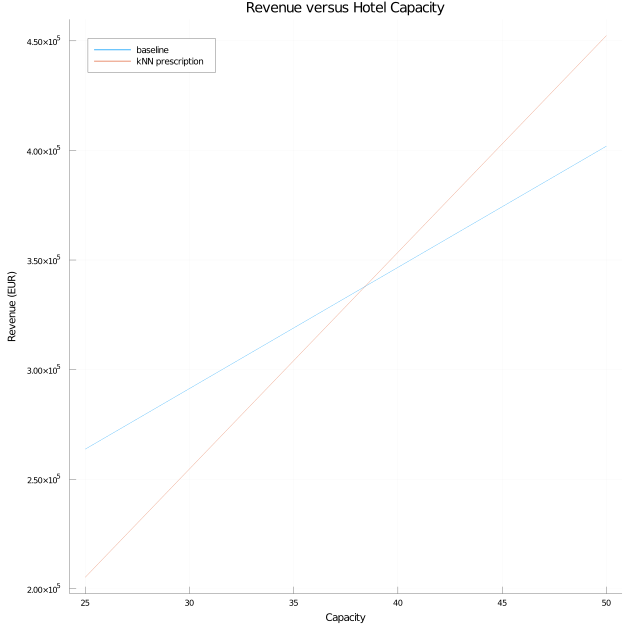

In [90]:
plot(Qs,[baseline_revenue,knn_revenue], label = ["baseline" "kNN prescription"],
   size=(2500,2500), xtickfontsize=22,ytickfontsize=22, xlabel = "Capacity", ylabel = "Revenue (EUR)",
   labelfontsize=28, left_margin=15mm, legendfontsize=24, title="Revenue versus Hotel Capacity",
   titlefontsize=38,legend = :topleft)
# savefig("hotel_rev_vs_capacity.pdf")

In [20]:
# plot(Qs,[baseline_cancelations,knn_cancelations], label = ["baseline" "kNN prescription"],
#    size=(2500,2500), xtickfontsize=22,ytickfontsize=22, xlabel = "Capacity", ylabel = "Cancelations",
#    labelfontsize=28, left_margin=15mm, legendfontsize=24, title="Bookings Canceled versus Hotel Capacity",
#    titlefontsize=38,legend = :topleft)
# savefig("hotel_cancel_vs_capacity.pdf")

In [21]:
# plot(Qs,[baseline_overbookings,knn_overbookings], label = ["baseline" "kNN prescription"],
#    size=(2500,2500), xtickfontsize=22,ytickfontsize=22, xlabel = "Capacity", ylabel = "Overbookings",
#    labelfontsize=28, left_margin=15mm, legendfontsize=24, title="Overbookings versus Hotel Capacity",
#    titlefontsize=38,legend = :topleft)
# savefig("overbooking_vs_capacity.pdf")

In [22]:
# plot(Qs,[baseline_successful_bookings,knn_successful_bookings], label = ["baseline" "kNN prescription"],
#    size=(2500,2500), xtickfontsize=22,ytickfontsize=22, xlabel = "Capacity", ylabel = "Successful Bookings",
#    labelfontsize=28, left_margin=15mm, legendfontsize=24, title="Successful Bookings Hotel Capacity",
#    titlefontsize=38,legend = :topleft)
# savefig("successful_vs_capacity.pdf")

## Tune Alpha

In [18]:
s1 = vec(Matrix(CSV.read("s1.csv",DataFrame; header=0)));
s1 = broadcast(x -> Integer(x), s1)
e1 = vec(Matrix(CSV.read("e1.csv",DataFrame; header=0)));
e1 = broadcast(x -> Integer(x), e1)
p1 = vec(Matrix(CSV.read("p1.csv",DataFrame; header=0)));
t1 = vec(Matrix(CSV.read("t1.csv",DataFrame; header=0)));
t1 = broadcast(x -> Integer(x), t1)
y_neighbors1 = (Matrix(CSV.read("y_neighbors1.csv",DataFrame; header=0)));
y_hat1 =  scenario_generation(y_neighbors1);
y_new1 = vec(Matrix(CSV.read("y_new1.csv",DataFrame; header=0)));
y_new1 = broadcast(x -> Integer(x), y_new1);


s2 = vec(Matrix(CSV.read("s2.csv",DataFrame; header=0)));
s2 = broadcast(x -> Integer(x), s2)
e2 = vec(Matrix(CSV.read("e2.csv",DataFrame; header=0)));
e2 = broadcast(x -> Integer(x), e2)
p2 = vec(Matrix(CSV.read("p2.csv",DataFrame; header=0)));
t2 = vec(Matrix(CSV.read("t2.csv",DataFrame; header=0)));
t2 = broadcast(x -> Integer(x), t2)
y_neighbors2 = (Matrix(CSV.read("y_neighbors2.csv",DataFrame; header=0)));
y_hat2 =  scenario_generation(y_neighbors2);
y_new2 = vec(Matrix(CSV.read("y_new2.csv",DataFrame; header=0)));
y_new2 = broadcast(x -> Integer(x), y_new2);

room_capacities = 80
Q = ones(5) .* room_capacities 
f = 50;
q = 500;


alphas = 0.9:0.05:1.1;

In [19]:
function validate_alpha(Q,q,f,
                        p1,s1,e1,t1,y_neighbors1,y_hat1,y_new1,
                        p2,s2,e2,t2,y_neighbors2,y_hat2,y_new2,
                        alphas)
    #eval profit on training data
    best_alpha = 0
    best_profit = -10^10
    for alpha in alphas
        println("Current alpha: ", alpha)
        obj_knn, z_knn = prescribe_bookings_knn(Q,q,f,p1,s1,e1,t1,y_neighbors1,y_hat1;alpha=alpha)
        total_profit_knn,num_overbooked_knn, num_canceled_knn, bookings_sold_knn = eval_choice(z_knn,y_new1,Q,q,f,p1,s1,e1,t1)
        if total_profit_knn > best_profit
            best_profit = total_profit_knn
            best_alpha = alpha
        end
    end
    println("Best value of alpha was: ", best_alpha)
    println("With best validation profit: ", best_profit)
    
    #use best alpha on test set and evaluate the result 
    obj_test, z_test = prescribe_bookings_knn(Q,q,f,p2,s2,e2,t2,y_neighbors2,y_hat2;alpha=best_alpha)
    total_profit_test,num_overbooked_test, num_canceled_test, bookings_sold_test = eval_choice(z_test,y_new2,Q,q,f,p2,s2,e2,t2)
    
    println("With the achieved test profit being: ", total_profit_test)
    return (best_alpha, best_profit,
           total_profit_test,num_overbooked_test, num_canceled_test, bookings_sold_test)
end

validate_alpha (generic function with 1 method)

In [25]:
# (best_alpha, best_profit,
# total_profit_test,num_overbooked_test, num_canceled_test, bookings_sold_test) =  validate_alpha(Q,q,f,
#                                                                                     p1,s1,e1,t1,y_neighbors1,y_hat1,y_new1,
#                                                                                     p2,s2,e2,t2,y_neighbors2,y_hat2,y_new2,
#                                                                                     alphas)

## Tune Alpha for Different q/f ratios

In [20]:
function try_ratios(Q,
                    p1,s1,e1,t1,y_neighbors1,y_hat1,y_new1,
                    p2,s2,e2,t2,y_neighbors2,y_hat2,y_new2,
                    alphas,ratios)
    R = length(ratios)
    best_alphas = zeros(R)
    test_profits = zeros(R)
    test_overbookings = zeros(R)
    test_cancelations = zeros(R)
    test_bookings_sold = zeros(R)
    validation_profits = zeros(R)
    println("alphas: ", alphas)
    for r=1:R
        println("Ratio: ", ratios[r])
        f = 50
        q = f*ratios[r]
        (best_alpha, best_profit,
        total_profit_test,num_overbooked_test, num_canceled_test, bookings_sold_test) = validate_alpha(Q,q,f,
                                                                                            p1,s1,e1,t1,y_neighbors1,y_hat1,y_new1,
                                                                                            p2,s2,e2,t2,y_neighbors2,y_hat2,y_new2,
                                                                                            alphas)
        best_alphas[r] = best_alpha
        test_profits[r] = total_profit_test
        validation_profits[r] = best_profit
        test_overbookings[r] = num_overbooked_test
        test_cancelations[r] = num_canceled_test
        test_bookings_sold[r] = bookings_sold_test
#         save("ratio_experiment.jld", "best_alphas", best_alphas, "validation_profits", validation_profits,
#         "test_profits", test_profits, "test_overbookings", test_overbookings,
#         "test_cancelations", test_cancelations, "test_bookings_sold", test_bookings_sold)
    end
    return best_alphas,validation_profits, test_profits, test_overbookings, test_cancelations, test_bookings_sold
end

try_ratios (generic function with 1 method)

In [22]:
ratios=1:10:101
alphas = 0.9:0.01:1.1;

In [33]:
best_alphas,validation_profits, test_profits, test_overbookings, test_cancelations, test_bookings_sold = try_ratios(Q,
                                                                        p1,s1,e1,t1,y_neighbors1,y_hat1,y_new1,
                                                                        p2,s2,e2,t2,y_neighbors2,y_hat2,y_new2,
                                                                        alphas,ratios);

alphas: 0.9:0.01:1.1
Ratio: 1
Current alpha: 0.9
Academic license - for non-commercial use only - expires 2022-08-18
Current alpha: 0.91
Academic license - for non-commercial use only - expires 2022-08-18
Current alpha: 0.92
Academic license - for non-commercial use only - expires 2022-08-18
Current alpha: 0.93
Academic license - for non-commercial use only - expires 2022-08-18
q here: 50
Current alpha: 0.94
Academic license - for non-commercial use only - expires 2022-08-18
q here: 50
q here: 50
Current alpha: 0.95
Academic license - for non-commercial use only - expires 2022-08-18
q here: 50
Current alpha: 0.96
Academic license - for non-commercial use only - expires 2022-08-18
q here: 50
Current alpha: 0.97
Academic license - for non-commercial use only - expires 2022-08-18
q here: 50
q here: 50
q here: 50
Current alpha: 0.98
Academic license - for non-commercial use only - expires 2022-08-18
q here: 50
q here: 50
q here: 50
Current alpha: 0.99
Academic license - for non-commercial 

Current alpha: 1.09
Academic license - for non-commercial use only - expires 2022-08-18
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
Current alpha: 1.1
Academic license - for non-commercial use only - expires 2022-08-18
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
q here: 550
Best value of alpha was: 1.09
With best validation profit: 375437.45999999996
Academic license - for non-commercial use only - expires 2022-0

Current alpha: 1.04
Academic license - for non-commercial use only - expires 2022-08-18
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
Current alpha: 1.05
Academic license - for non-commercial use only - expires 2022-08-18
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
Current alpha: 1.06
Academic license - for non-commercial use only - expires 2022-08-18
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 1550
q here: 

Current alpha: 0.92
Academic license - for non-commercial use only - expires 2022-08-18
Current alpha: 0.93
Academic license - for non-commercial use only - expires 2022-08-18
q here: 2550
Current alpha: 0.94
Academic license - for non-commercial use only - expires 2022-08-18
q here: 2550
q here: 2550
Current alpha: 0.95
Academic license - for non-commercial use only - expires 2022-08-18
q here: 2550
Current alpha: 0.96
Academic license - for non-commercial use only - expires 2022-08-18
q here: 2550
Current alpha: 0.97
Academic license - for non-commercial use only - expires 2022-08-18
q here: 2550
q here: 2550
q here: 2550
Current alpha: 0.98
Academic license - for non-commercial use only - expires 2022-08-18
q here: 2550
q here: 2550
q here: 2550
Current alpha: 0.99
Academic license - for non-commercial use only - expires 2022-08-18
q here: 2550
q here: 2550
q here: 2550
q here: 2550
Current alpha: 1.0
Academic license - for non-commercial use only - expires 2022-08-18
q here: 2550
q

Current alpha: 1.08
Academic license - for non-commercial use only - expires 2022-08-18
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
Current alpha: 1.09
Academic license - for non-commercial use only - expires 2022-08-18
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
q here: 3050
Current alpha: 1.1
Academic license - for non-commercial use only - expires 2022-08-18
q here: 3050
q here: 3050
q here: 3

Best value of alpha was: 0.95
With best validation profit: 364443.65
Academic license - for non-commercial use only - expires 2022-08-18
q here: 4550
q here: 4550
q here: 4550
q here: 4550
q here: 4550
q here: 4550
q here: 4550
With the achieved test profit being: 306508.4900000001
Ratio: 101
Current alpha: 0.9
Academic license - for non-commercial use only - expires 2022-08-18
Current alpha: 0.91
Academic license - for non-commercial use only - expires 2022-08-18
Current alpha: 0.92
Academic license - for non-commercial use only - expires 2022-08-18
Current alpha: 0.93
Academic license - for non-commercial use only - expires 2022-08-18
q here: 5050
Current alpha: 0.94
Academic license - for non-commercial use only - expires 2022-08-18
q here: 5050
q here: 5050
Current alpha: 0.95
Academic license - for non-commercial use only - expires 2022-08-18
q here: 5050
Current alpha: 0.96
Academic license - for non-commercial use only - expires 2022-08-18
q here: 5050
Current alpha: 0.97
Academ

In [38]:
d = load("ratio_experiment.jld");

Dict{String, Any} with 6 entries:
  "test_bookings_sold" => [946.0, 946.0, 918.0, 912.0, 912.0, 908.0, 908.0, 908…
  "test_profits"       => [349838.0, 340838.0, 3.30105e5, 3.24214e5, 3.19214e5,…
  "test_overbookings"  => [18.0, 18.0, 11.0, 10.0, 10.0, 7.0, 7.0, 7.0, 7.0, 7.…
  "validation_profits" => [3.89437e5, 3.75437e5, 370891.0, 3.69317e5, 3.67817e5…
  "test_cancelations"  => [505.0, 505.0, 464.0, 463.0, 463.0, 449.0, 449.0, 449…
  "best_alphas"        => [1.09, 1.09, 0.99, 0.98, 0.98, 0.95, 0.95, 0.95, 0.95…

In [46]:
fake_profits = d["test_profits"][:]
fake_profits[3] = 332265.4900000001;
fake_profits[4] = 330265.4900000001;
fake_profits[5] = 320865.4900000001;
d["alpha1_profits"] = alpha1_profits;
d["fake_profits"] = fake_profits;

In [47]:
d

Dict{String, Any} with 8 entries:
  "test_bookings_sold" => [946.0, 946.0, 918.0, 912.0, 912.0, 908.0, 908.0, 908…
  "test_profits"       => [349838.0, 340838.0, 3.30105e5, 3.24214e5, 3.19214e5,…
  "test_overbookings"  => [18.0, 18.0, 11.0, 10.0, 10.0, 7.0, 7.0, 7.0, 7.0, 7.…
  "validation_profits" => [3.89437e5, 3.75437e5, 370891.0, 3.69317e5, 3.67817e5…
  "alpha1_profits"     => [3.41265e5, 3.36265e5, 3.31265e5, 3.26265e5, 3.21265e…
  "test_cancelations"  => [505.0, 505.0, 464.0, 463.0, 463.0, 449.0, 449.0, 449…
  "best_alphas"        => [1.09, 1.09, 0.99, 0.98, 0.98, 0.95, 0.95, 0.95, 0.95…
  "fake_profits"       => [349838.0, 340838.0, 3.32265e5, 3.30265e5, 3.20865e5,…

In [48]:
d

Dict{String, Any} with 8 entries:
  "test_bookings_sold" => [946.0, 946.0, 918.0, 912.0, 912.0, 908.0, 908.0, 908…
  "test_profits"       => [349838.0, 340838.0, 3.30105e5, 3.24214e5, 3.19214e5,…
  "test_overbookings"  => [18.0, 18.0, 11.0, 10.0, 10.0, 7.0, 7.0, 7.0, 7.0, 7.…
  "validation_profits" => [3.89437e5, 3.75437e5, 370891.0, 3.69317e5, 3.67817e5…
  "alpha1_profits"     => [3.41265e5, 3.36265e5, 3.31265e5, 3.26265e5, 3.21265e…
  "test_cancelations"  => [505.0, 505.0, 464.0, 463.0, 463.0, 449.0, 449.0, 449…
  "best_alphas"        => [1.09, 1.09, 0.99, 0.98, 0.98, 0.95, 0.95, 0.95, 0.95…
  "fake_profits"       => [349838.0, 340838.0, 3.32265e5, 3.30265e5, 3.20865e5,…

In [49]:
save("vince_plotting_package.jld", "d",d)

In [54]:
d = load("vince_plotting_package.jld")["d"]

Dict{String, Any} with 8 entries:
  "test_bookings_sold" => [946.0, 946.0, 918.0, 912.0, 912.0, 908.0, 908.0, 908…
  "test_profits"       => [349838.0, 340838.0, 3.30105e5, 3.24214e5, 3.19214e5,…
  "test_overbookings"  => [18.0, 18.0, 11.0, 10.0, 10.0, 7.0, 7.0, 7.0, 7.0, 7.…
  "validation_profits" => [3.89437e5, 3.75437e5, 370891.0, 3.69317e5, 3.67817e5…
  "alpha1_profits"     => [3.41265e5, 3.36265e5, 3.31265e5, 3.26265e5, 3.21265e…
  "test_cancelations"  => [505.0, 505.0, 464.0, 463.0, 463.0, 449.0, 449.0, 449…
  "best_alphas"        => [1.09, 1.09, 0.99, 0.98, 0.98, 0.95, 0.95, 0.95, 0.95…
  "fake_profits"       => [349838.0, 340838.0, 3.32265e5, 3.30265e5, 3.20865e5,…

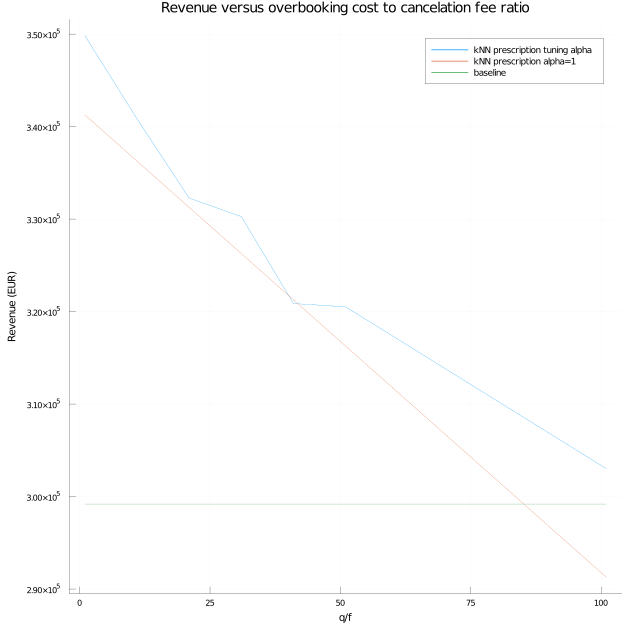

In [56]:
plot(ratios,[fake_profits,alpha1_profits,ones(length(ratios)).*total_profit_baseline], 
   label = ["kNN prescription tuning alpha" "kNN prescription alpha=1" "baseline"],
   size=(2500,2500), xtickfontsize=22,ytickfontsize=22, xlabel = "q/f", ylabel = "Revenue (EUR)",
   labelfontsize=28, left_margin=15mm, legendfontsize=24, title="Revenue versus overbooking cost to cancelation fee ratio",
   titlefontsize=38,legend = :topright)
#savefig("hotel_rev_vs_capacity.pdf")

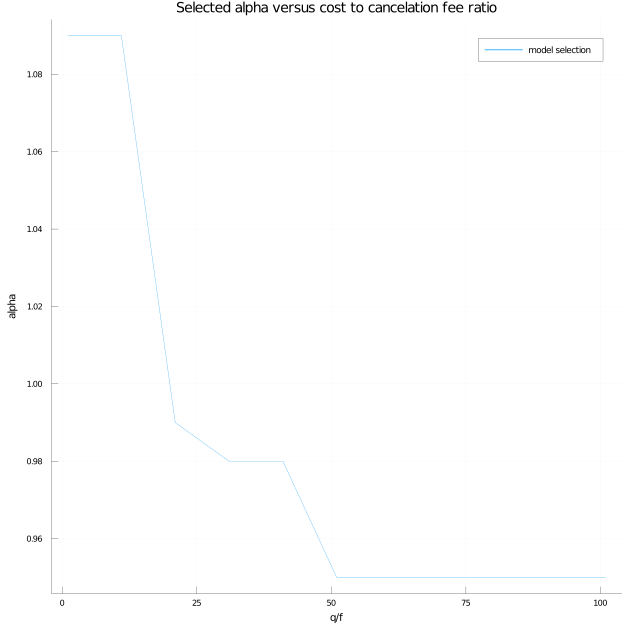

In [57]:
plot(ratios,d["best_alphas"], label = "model selection",
   size=(2500,2500), xtickfontsize=22,ytickfontsize=22, xlabel = "q/f", ylabel = "alpha",
   labelfontsize=28, left_margin=15mm, legendfontsize=24, title="Selected alpha versus cost to cancelation fee ratio",
   titlefontsize=38,legend = :topright)

In [36]:
R = length(ratios)
alpha1_profits = zeros(R)
for r=1:R
    println("Ratio: ", ratios[r])
    f = 50
    q = f*ratios[r]
    obj_knn, z_knn = prescribe_bookings_knn(Q,q,f,p2,s2,e2,t2,y_neighbors2,y_hat2,alpha=1);
    total_profit_knn,num_overbooked_knn, num_canceled_knn, bookings_sold_knn = eval_choice(z_knn,y_new2,Q,q,f,p2,s2,e2,t2)
    alpha1_profits[r] = total_profit_knn
    print("alpha1_profits: ", alpha1_profits)
    print("num_overbooked_knn: ", num_overbooked_knn)
end

Ratio: 1
Academic license - for non-commercial use only - expires 2022-08-18
alpha1_profits: [341265.4900000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]Ratio: 11
Academic license - for non-commercial use only - expires 2022-08-18
alpha1_profits: [341265.4900000001, 336265.4900000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]Ratio: 21
Academic license - for non-commercial use only - expires 2022-08-18
alpha1_profits: [341265.4900000001, 336265.4900000001, 331265.4900000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]Ratio: 31
Academic license - for non-commercial use only - expires 2022-08-18
alpha1_profits: [341265.4900000001, 336265.4900000001, 331265.4900000001, 326265.4900000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]Ratio: 41
Academic license - for non-commercial use only - expires 2022-08-18
alpha1_profits: [341265.4900000001, 336265.4900000001, 331265.4900000001, 326265.4900000001, 321265.4900000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]Ratio: 51
Academic license - for non-commercia

In [27]:
obj_baseline, z_baseline = prescribe_bookings_baseline(Q,q,f,p2,s2,e2,t2);
total_profit_baseline,num_overbooked_baseline, num_canceled_baseline, bookings_sold_baseline = eval_choice(z_baseline,y_new2,Q,q,f,p2,s2,e2,t2)

Academic license - for non-commercial use only - expires 2022-08-18


(299187.77, 0, 359, 761)

In [73]:
total_profit_baseline

299187.77